In [113]:
from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

1. Obtenção de dados

In [114]:
df = pd.read_csv('../data/raw/data.csv')
df_dict = pd.read_csv('../data/raw/dic_data 2.csv')
df_dict

,variavel,descrição,tipo,subtipo
0,carat,Quantidade de massa representada em Quilates,Quantitativo,Contínua
1,cut,Qualidade de corte do diamante,Qualitativo,Nominal
2,color,Cor do diamante em alfanumérica,Qualitativo,Nominal
3,clarity,Classificação de clareza do diamante,Qualitativo,Nominal
4,depth,Profundidade total em porcentagem,Quantitativa,Discreta
5,table,Largura do topo do diamante relativo ao ponto ...,Quantitativo,Contínua
6,price,Preço em dolar,Quantitativo,Contínua
7,volume,"Multiplicação dos valores das variáveis: X,Y e Z",Quantitativo,Contínua


Preparação dos Dados


- Apesar de não serem dados NaN, quando o valor de X,Y ou Z forem iguais a 0, é um missing data, pois não faz sentido

In [115]:
len_missin = len(df[(df['x']<=0) | (df['y']<=0) | (df['z']<=0)])
print(f"antes da limpeza o numero de dados que não fazem sentido em X,Y ou Z é: {len_missin}")
df = df[(df[['x','y','z']] != 0).all(axis=1)]
print('Retiramos os dados sem sentido em X,Y ou Z! Tudo limpo!')


antes da limpeza o numero de dados que não fazem sentido em X,Y ou Z é: 20
Retiramos os dados sem sentido em X,Y ou Z! Tudo limpo!


In [116]:
df['volume'] = df['x']*df['y']*df['z'] 
df[:5]

df = df.drop(['x','y','z'], axis=1)
df[:5]

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,51.917250


In [117]:
target_column = "price"
nominal_columns = (
    df_dict
    .query("subtipo == 'Nominal'")
    .variavel
    .to_list()
)
continuous_columns = (
    df_dict
    .query("subtipo == 'Contínua' and variavel != @target_column")
    .variavel
    .to_list()
)

X = df.drop(columns=[target_column], axis=1)
y = df['price']

print(df.columns)
print(X.columns)
print(y)


Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'volume'],
      dtype='object')
Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'volume'], dtype='object')
0         326
1         326
2         327
3         334
4         335
         ... 
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53920, dtype: int64


In [124]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ('encoding', OneHotEncoder(sparse_output=False, drop='first')), # codificação de variáveis
    ('normalization', StandardScaler()) # normalização de dados
])
continuous_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), # tratamento de dados faltantes
    ('normalization', StandardScaler()) # normalização de dados
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('continuous', continuous_preprocessor, continuous_columns)
])

# Criando o pipeline completo
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())  # Substitua pelo modelo que você deseja usa
])

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo e fazendo previsões
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

# Avaliando o modelo
print('Score:', model_pipeline.score(X_test, y_test))


Score: 0.9768561636923072


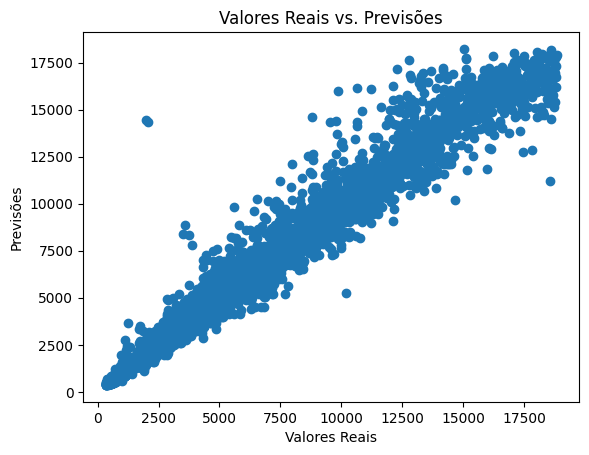

In [125]:
import matplotlib.pyplot as plt

# Plotando valores reais vs. previsões
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Valores Reais vs. Previsões')
plt.show()
